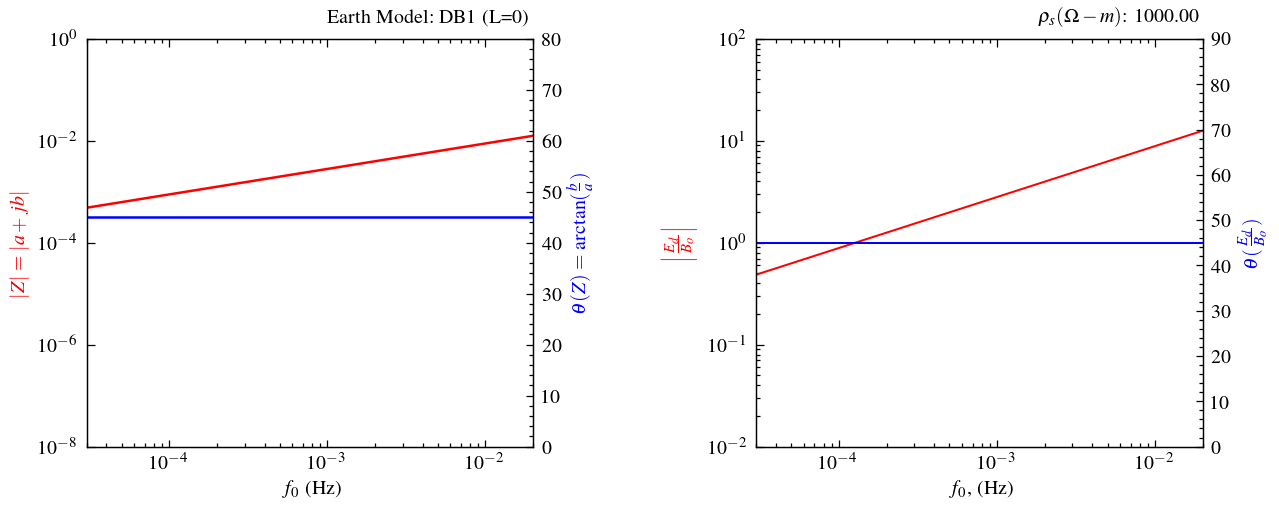

In [1]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
import numpy as np
from models import LayeredOcean

lo = LayeredOcean(model_name="DB1", flim=[3e-5,2e-2])
lo.resistivities[:] = 1000
fig = plt.figure(dpi=180, figsize=(8, 3))
lo.calcZ(ocean=False)
lo.plot_impedance(fig.add_subplot(121), layer=0)
lo.plotTFMagPhase(ax=fig.add_subplot(122), ylims=[1e-2,1e2], th=0)
fig.subplots_adjust(wspace=0.5, hspace=0.5)

In [2]:
Am = np.array([200, 90, 30, 17, 8, 3.5, 1])
Phim = np.array([10, 20, 30, 40, 50, 60, 70])
fm = np.array([0.00009259, 0.00020833, 0.00047619, 0.00111111, 0.00238095, 0.00555555, 0.025])

t = np.linspace(0,60*60*24,60*60*24)
B = np.zeros((7, len(t)))
for m in range(7):
    B[m,:] = Am[m]*np.sin((2*np.pi*fm[m]*t + np.deg2rad(Phim[m])))
Bt = np.sum(B, axis=0)

E = np.zeros((7, len(t)))
for m in range(7):
    Km = lo.calcTFRec(fm[m])
    E[m,:] = np.absolute(Km)*1e3 * Am[m]*np.sin((2*np.pi*fm[m]*t + np.angle(Km) + np.deg2rad(Phim[m])))
Et = np.sum(E, axis=0)

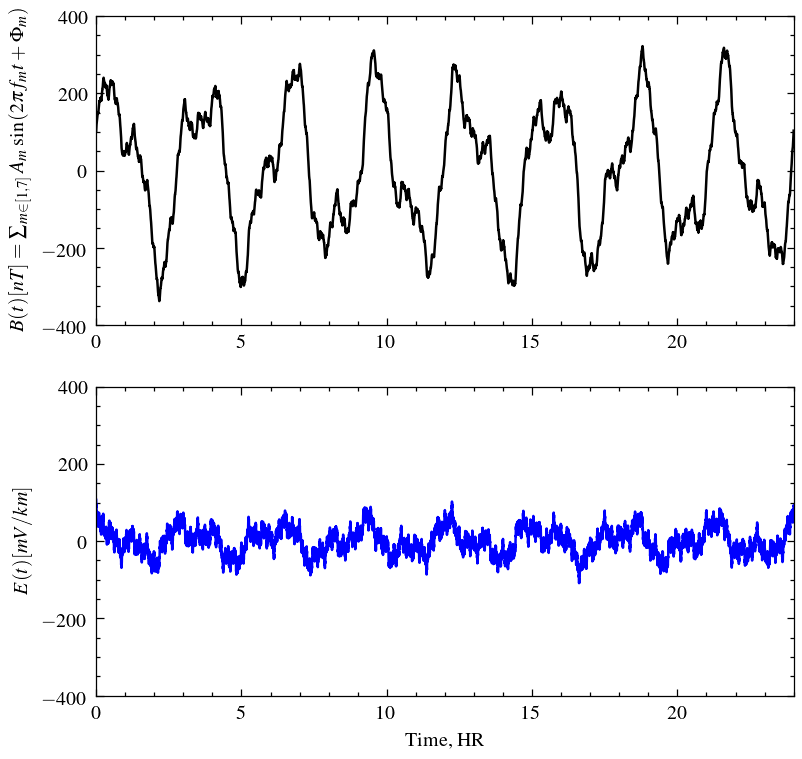

In [3]:
t0 = t/3600.
fig = plt.figure(dpi=180, figsize=(5, 5))
ax = fig.add_subplot(211)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,7]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_xlim(0, t0[-1])
ax.set_ylim(-400,400)
ax = fig.add_subplot(212)
ax.plot(t0, Et, "b")
ax.set_xlabel("Time, HR")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-400,400)